In [1]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/marquis03/bean-leaf-lesions-classification")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:

  InsaneJSK


Your Kaggle Key:

  ········


Dataset URL: https://www.kaggle.com/datasets/marquis03/bean-leaf-lesions-classification


100%|██████████| 155M/155M [00:00<00:00, 1.21GB/s]

In [2]:
import torch
from torch import nn
from torch.optim import Adam
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, Dataset
from torchvision import models
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np
import os

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [55]:
train_df = pd.read_csv("/kaggle/working/bean-leaf-lesions-classification/train.csv")
val_df = pd.read_csv("/kaggle/working/bean-leaf-lesions-classification/val.csv")

train_df["image:FILE"] = "/kaggle/working/bean-leaf-lesions-classification/" + train_df["image:FILE"]
val_df["image:FILE"] = "/kaggle/working/bean-leaf-lesions-classification/" + val_df["image:FILE"]

In [56]:
train_df.head()

,image:FILE,category
0,/kaggle/working/bean-leaf-lesions-classificati...,0
1,/kaggle/working/bean-leaf-lesions-classificati...,0
2,/kaggle/working/bean-leaf-lesions-classificati...,0
3,/kaggle/working/bean-leaf-lesions-classificati...,0
4,/kaggle/working/bean-leaf-lesions-classificati...,0


In [57]:
train_df.shape, val_df.shape

((1034, 2), (133, 2))

In [58]:
train_df['category'].value_counts()

category
2    348
1    345
0    341
Name: count, dtype: int64

In [59]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1034 entries, 0 to 1033
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image:FILE  1034 non-null   object
 1   category    1034 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 16.3+ KB


In [60]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float)
])

In [61]:
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, transform):
        self.dataframe = dataframe
        self.transform = transform
        self.labels = torch.tensor(dataframe["category"]).to(device)

    def __len__(self):
        return self.dataframe.shape[0]

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        label = self.labels[idx]
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)/255.0

        return image, label

In [62]:
train_dataset = CustomImageDataset(dataframe = train_df, transform = transform)
val_dataset = CustomImageDataset(dataframe = val_df, transform = transform)

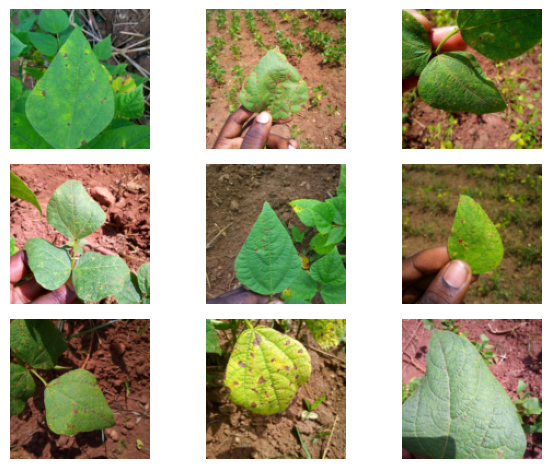

In [64]:
n_rows = 3
n_cols = 3

f, axarr = plt.subplots(n_rows, n_cols)

for row in range(n_rows):
    for col in range(n_cols):
        image = train_dataset[np.random.randint(0, train_dataset.__len__())][0].cpu()
        axarr[row, col].imshow((image*255.0).squeeze().permute(1, 2, 0))
        axarr[row, col].axis("off")

plt.tight_layout()
plt.show()

In [65]:
LR = 1e-3
BATCH_SIZE = 4
EPOCHS = 15

In [66]:
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = True)

In [68]:
googlenet_model = models.googlenet(weights = "DEFAULT")

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 182MB/s]


In [69]:
for param in googlenet_model.parameters():
    param.required_grad = True

In [70]:
googlenet_model.fc

Linear(in_features=1024, out_features=1000, bias=True)

In [71]:
num_classes = len(train_df["category"].unique())
num_classes

3

In [72]:
googlenet_model.fc = torch.nn.Linear(googlenet_model.fc.in_features, num_classes)
googlenet_model.fc

Linear(in_features=1024, out_features=3, bias=True)

In [74]:
googlenet_model.to(device)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [78]:
loss_fun = nn.CrossEntropyLoss()
optimizer = Adam(googlenet_model.parameters(), lr = LR)

total_loss_train_plot = []
total_acc_train_plot = []

for epoch in range(EPOCHS):
    total_acc_train = 0
    total_loss_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = googlenet_model(inputs)
        train_loss = loss_fun(outputs, labels)
        total_loss_train += train_loss.item()

        train_loss.backward()

        train_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
        total_acc_train += train_acc
        optimizer.step()

    total_loss_train_plot.append(round(total_loss_train/1000, 4))
    total_acc_train_plot.append(round(total_acc_train/train_dataset.__len__()*100, 4))
    print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {round(total_loss_train/1000, 4)}, Train Accuracy: {round(total_acc_train/train_dataset.__len__()*100, 4)} %")

Epoch 1/15, Train Loss: 0.2215, Train Accuracy: 60.6383 %
Epoch 2/15, Train Loss: 0.2086, Train Accuracy: 62.8627 %
Epoch 3/15, Train Loss: 0.1993, Train Accuracy: 65.8607 %
Epoch 4/15, Train Loss: 0.1846, Train Accuracy: 68.8588 %
Epoch 5/15, Train Loss: 0.165, Train Accuracy: 73.7911 %
Epoch 6/15, Train Loss: 0.1718, Train Accuracy: 72.5338 %
Epoch 7/15, Train Loss: 0.1519, Train Accuracy: 77.5629 %
Epoch 8/15, Train Loss: 0.1471, Train Accuracy: 75.1451 %
Epoch 9/15, Train Loss: 0.1523, Train Accuracy: 77.5629 %
Epoch 10/15, Train Loss: 0.1391, Train Accuracy: 78.9168 %
Epoch 11/15, Train Loss: 0.1296, Train Accuracy: 80.5609 %
Epoch 12/15, Train Loss: 0.1249, Train Accuracy: 81.0445 %
Epoch 13/15, Train Loss: 0.1236, Train Accuracy: 81.4313 %
Epoch 14/15, Train Loss: 0.1184, Train Accuracy: 80.6576 %
Epoch 15/15, Train Loss: 0.1104, Train Accuracy: 84.1393 %


In [83]:
with torch.no_grad():
    total_acc_test = 0

    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        prediction = googlenet_model(inputs)
        acc = (torch.argmax(prediction, axis = 1) == labels).sum().item()
        total_acc_test += acc

In [84]:
print(round(total_acc_test/val_dataset.__len__()*100, 2))

82.71


In [87]:
for param in googlenet_model.parameters():
    param.requires_grad = False

googlenet_model.fc = torch.nn.Linear(googlenet_model.fc.in_features, num_classes)
googlenet_model.fc
googlenet_model.to(device)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [88]:
loss_fun = nn.CrossEntropyLoss()
optimizer = Adam(googlenet_model.parameters(), lr = LR)

total_loss_train_plot = []
total_acc_train_plot = []

for epoch in range(EPOCHS):
    total_acc_train = 0
    total_loss_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = googlenet_model(inputs)
        train_loss = loss_fun(outputs, labels)
        total_loss_train += train_loss.item()

        train_loss.backward()

        train_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
        total_acc_train += train_acc
        optimizer.step()

    total_loss_train_plot.append(round(total_loss_train/1000, 4))
    total_acc_train_plot.append(round(total_acc_train/train_dataset.__len__()*100, 4))
    print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {round(total_loss_train/1000, 4)}, Train Accuracy: {round(total_acc_train/train_dataset.__len__()*100, 4)} %")

Epoch 1/15, Train Loss: 0.1333, Train Accuracy: 81.3346 %
Epoch 2/15, Train Loss: 0.1156, Train Accuracy: 82.9787 %
Epoch 3/15, Train Loss: 0.1096, Train Accuracy: 83.7524 %
Epoch 4/15, Train Loss: 0.1058, Train Accuracy: 84.5261 %
Epoch 5/15, Train Loss: 0.1182, Train Accuracy: 84.4294 %
Epoch 6/15, Train Loss: 0.1043, Train Accuracy: 85.9768 %
Epoch 7/15, Train Loss: 0.1095, Train Accuracy: 84.5261 %
Epoch 8/15, Train Loss: 0.0964, Train Accuracy: 85.6867 %
Epoch 9/15, Train Loss: 0.1027, Train Accuracy: 86.4603 %
Epoch 10/15, Train Loss: 0.112, Train Accuracy: 84.0426 %
Epoch 11/15, Train Loss: 0.0949, Train Accuracy: 85.4932 %
Epoch 12/15, Train Loss: 0.0968, Train Accuracy: 87.1373 %
Epoch 13/15, Train Loss: 0.0968, Train Accuracy: 86.4603 %
Epoch 14/15, Train Loss: 0.1335, Train Accuracy: 81.6248 %
Epoch 15/15, Train Loss: 0.1084, Train Accuracy: 85.2031 %


In [89]:
with torch.no_grad():
    total_acc_test = 0

    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        prediction = googlenet_model(inputs)
        acc = (torch.argmax(prediction, axis = 1) == labels).sum().item()
        total_acc_test += acc

In [90]:
print(round(total_acc_test/val_dataset.__len__()*100, 2))

75.94
